# San Antonio Melee tournament data June 4th - August-27

## 1. Import libraries

In [20]:
import pandas as pd
import xml.etree.cElementTree as et
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Parse SkillKeeper "Summer PR Draft 1.bcn" (bacon?) file
It's actually just an xml file

In [68]:
# open the matches file
matches_file = "Summer PR Draft 1.bcn"
with open(matches_file, 'r') as f:
    file = f.readlines()

# print the first 5 lines
for x in range(5):
    print(file[x])

﻿<?xml version="1.0" encoding="utf-8"?>

<SK92>

  <Settings Multiplier="200" MinMatches="4" Decay="3" DecayValue="2" />

  <Players>

    <Player Name="Arc" Team="" Invisible="false" Characters="" Alts="FX | Arc" />



### Parse Summer PR Draft 1.bcn with the built in xml library's `xml.etree.ElementTree.parse()`
* https://docs.python.org/3/library/xml.etree.elementtree.html#xml.etree.ElementTree.parse

In [70]:
# parse bcn file (just xml)
parsedXML = et.parse(matches_file)

### SkillKeeper settings
* https://docs.python.org/3/library/xml.etree.elementtree.html#xml.etree.ElementTree.ElementTree.getroot
* https://docs.python.org/3/library/xml.etree.elementtree.html#xml.etree.ElementTree.ElementTree.find

In [67]:
# settings
multipler = parsedXML.getroot().find("Settings").get('Multiplier')
minmatches = parsedXML.getroot().find("Settings").get('MinMatches')
decay = parsedXML.getroot().find("Settings").get('Decay')
decayValue = parsedXML.getroot().find("Settings").get('DecayValue')
print("Settings: \n Multiplier: {} \n Min Matches: {} \n Decay: {} \n Decay Value: {} \n". format(multipler, minmatches, decay, decayValue))

Settings: 
 Multiplier: 200 
 Min Matches: 4 
 Decay: 3 
 Decay Value: 2 



### Turn matches into list, and turn that list into a Pandas DataFrame
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [71]:
# parse matches into list of dicts
matches = []
for match in list(parsedXML.getroot().find("Matches")):
    matches.append({
        "id": match.get("ID"),
        "timestamp": match.get("Timestamp"),
        "order": match.get("order"),
        "tournament": match.get("Tournament"),
        "description": match.get("Description"),
        "player1": match.get("Player1"),
        "player2": match.get("Player2"),
        "winner": match.get("Winner")
    })
    
# pass list of dicts to pandas
matches_df = pd.DataFrame(matches)
matches_df.head()

,description,id,order,player1,player2,timestamp,tournament,winner
0,sanantoniomelee - Muramasa Monday Redemption 66,ab707ee35e224f5187754a431cf9a565,None,Mighty,Riff,6/4/2018 9:46:48 PM,Muramasa Monday Redemption 66,1
1,sanantoniomelee - Muramasa Monday Redemption 66,77f18550f24a46f6ae68a3cf95789760,None,Blitz,PopStar,6/4/2018 9:46:48 PM,Muramasa Monday Redemption 66,2
2,sanantoniomelee - Muramasa Monday Redemption 66,79c81769f81f4c4ea9c6c792790242f6,None,Clipman,Velocity,6/4/2018 9:46:48 PM,Muramasa Monday Redemption 66,1
3,sanantoniomelee - Muramasa Monday Redemption 66,fa024be387254276aacb5201a1f9b179,None,HS,Deca,6/4/2018 9:46:48 PM,Muramasa Monday Redemption 66,1
4,sanantoniomelee - Muramasa Monday Redemption 66,9c58853a1af647c6b18791bb81fba8e7,None,Bean,Your Dad's Yoshi,6/4/2018 9:46:48 PM,Muramasa Monday Redemption 66,1


### Turn players into list, turn that list into a Pandas DataFrame

In [113]:
# parse players into a list of dicts
players = []
for player in parsedXML.getroot().find("Players").getchildren():
    players.append({
        "name": player.get("Name"),
        "team": player.get("Team"),
        "invisible": player.get("Invisible"),
        "characters": player.get("Characters"),
        "alts": player.get("Alts")
    })
# pass list of dicts into pandas
players_df = pd.DataFrame(players)
players_df.head()
players_df = players_df.set_index("name")
# turn alts in matches_df into primary name

player1_wins = matches_df.loc[matches_df['winner'] == "1"]
player2_wins = matches_df.loc[matches_df['winner'] == "2"]

players_df = pd.concat((players_df, player1_wins['player1'].value_counts().rename("p1wins")), axis=1)
players_df = pd.concat((players_df, player1_wins['player2'].value_counts().rename("p1losses")), axis=1)
players_df = pd.concat((players_df, player2_wins['player2'].value_counts().rename("p2wins")), axis=1)
players_df = pd.concat((players_df, player2_wins['player1'].value_counts().rename("p2losses")), axis=1)

# count matches
player2_counts = matches_df['player2'].value_counts()
player1_counts = matches_df['player1'].value_counts()

players_df = players_df.join(player1_counts)
players_df = players_df.join(player2_counts)

players_df = players_df.fillna(0)


players_df['total_wins'] = players_df['p1wins'] + players_df['p2wins']
players_df['total_losses'] = players_df['p1losses'] + players_df['p2losses']
players_df['total_matches'] = players_df['player1'] + players_df['player2']
players_df['win_ratio'] = players_df['total_wins'] / players_df['total_losses']
players_df = players_df.reset_index()
players_df.head()

/Users/f00/anaconda/envs/machine_learning_cookbook/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/f00/anaconda/envs/machine_learning_cookbook/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/f00/anaconda/envs/machine_learning_cookbook/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, 

,index,alts,characters,invisible,team,p1wins,p1losses,p2wins,p2losses,player1,player2,total_wins,total_losses,total_matches,win_ratio
0,4SK,,,false,,6.0,7.0,6.0,1.0,7.0,13,12.0,8.0,20.0,1.500000
1,5ive,5,,false,,12.0,6.0,4.0,0.0,12.0,10,16.0,6.0,22.0,2.666667
2,Abby,,,false,,2.0,6.0,4.0,2.0,4.0,10,6.0,8.0,14.0,0.750000
3,Africa,,,false,,0.0,4.0,0.0,0.0,0.0,4,0.0,4.0,4.0,0.000000
4,Afukasi,,,false,,0.0,2.0,0.0,0.0,0.0,2,0.0,2.0,2.0,0.000000


## 3. Some numbers and graphs

#### number of players, number of matches, and number of tournaments

In [97]:
# number of players, number of matches, number of tournaments
num_players = len(players_df)
num_matches = len(matches_df)
num_tournaments = len(matches_df['tournament'].unique())
print("Number of Players: {}".format(num_players))
print("Number of Matches: {}".format(num_matches))
print("Number of Tournaments: {}".format(num_tournaments))

Number of Players: 134
Number of Matches: 1818
Number of Tournaments: 52


#### unique player matchups

In [98]:
# number of unique player1 player 2 matches
len(matches_df[['player1', 'player2']].drop_duplicates())

1221

#### bar graph of top 10 players by total matches

Text(0,0.5,'Player')

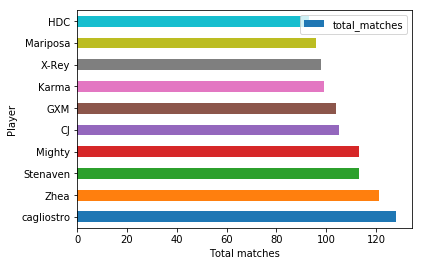

In [99]:
players_df = players_df.sort_values('total_matches', ascending=False)
total_matches_by_player_plot = players_df[:10].reset_index().plot(x='index', y='total_matches', kind="barh")
total_matches_by_player_plot.set_xlabel('Total matches')
total_matches_by_player_plot.set_ylabel('Player')

#### bar graph of top 10 players by total wins

Text(0,0.5,'Player')

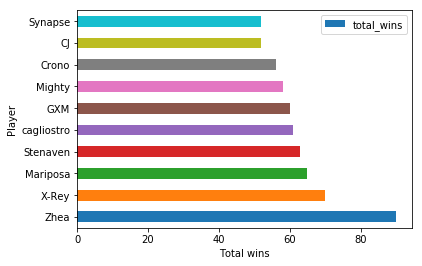

In [100]:
players_df = players_df.sort_values('total_wins', ascending=False)
total_wins_by_player_plot = players_df[:10].plot(x='index', y='total_wins', kind="barh")
total_wins_by_player_plot.set_xlabel('Total wins')
total_wins_by_player_plot.set_ylabel('Player')

#### bar graph of top 10 players by total losses (grats to cagliostro)

Text(0,0.5,'Player')

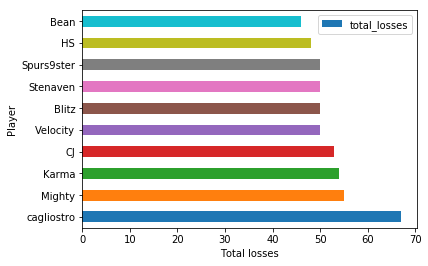

In [101]:
players_df = players_df.sort_values('total_losses', ascending=False)
total_losses_by_player_plot = players_df[:10].plot(x='index', y='total_losses', kind="barh")
total_losses_by_player_plot.set_xlabel('Total losses')
total_losses_by_player_plot.set_ylabel('Player')

#### bar graph of top 10 players by win/loss ratio

Text(0,0.5,'Player')

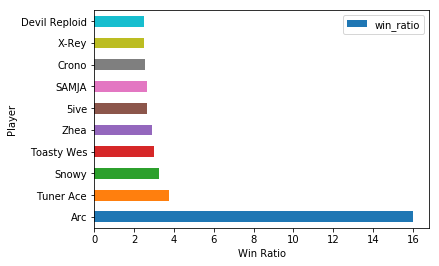

In [102]:
players_df = players_df.sort_values('win_ratio', ascending=False)
win_ratio_by_player_plot = players_df[:10].plot(x='index', y='win_ratio', kind="barh")
win_ratio_by_player_plot.set_xlabel('Win Ratio')
win_ratio_by_player_plot.set_ylabel('Player')

## 4. Ranking using TrueSkill
#### SkillKeeper uses this java library: https://github.com/moserware/Skills)
there is a library that tries to port Moserware's Skills library from Java, just not enough documentation
* https://github.com/McLeopold/PythonSkills/


this library is a simple implemention of trueskill, nice but same problem
* https://github.com/dougz/trueskill


and this is the one i actually used
* https://github.com/sublee/trueskill
* http://trueskill.org/
* https://github.com/sublee/trueskill/blob/master/docs/index.rst

*shout out to Heungsub Lee for making this easy for me*

In [103]:
from trueskill import Rating, rate_1vs1

# convert timestamps from strings to datetime64
matches_df['timestamp'] = pd.to_datetime(matches_df['timestamp'])

# lets sort by timestamp so we can go through the matches in chronological order
matches_df.sort_values("timestamp", ascending=True)

# create Rating for every player
ratings = dict()
for index, player in players_df.iterrows():
    ratings[player['index']] = Rating()

# go through every match and update winner's and loser's rating
for index, match in matches_df.iterrows():
    player1 = match['player1']
    player2 = match['player2']
    
    if match['winner'] == "1":
        ratings[player1], ratings[player2] = rate_1vs1(ratings[player1], ratings[player2])
    elif match['winner'] == "2":
        ratings[player1], ratings[player2] = rate_1vs1(ratings[player1], ratings[player2])
    elif match['winner'] == "0":
        ratings[player1], ratings[player2] = rate_1vs1(ratings[player1], ratings[player2], drawn=True)

In [104]:
# players sort by mu
mu_sorted_ratings = sorted(ratings.items(), key=lambda x: x[1].mu, reverse=True)
# players sort by sigma
sigma_sorted_ratings = sorted(ratings.items(), key=lambda x: x[1].sigma, reverse=True)

## list comphrensions to make nice lists for matplotlib
* https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions
* https://matplotlib.org/api/_as_gen/matplotlib.pyplot.bar.html


### top 20

<BarContainer object of 20 artists>

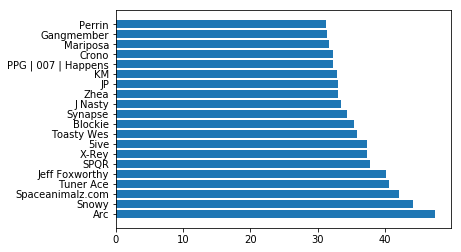

In [111]:
players = [player[0] for player in mu_sorted_ratings[:20]]
ratings = [player[1].mu for player in mu_sorted_ratings[:20]]
plt.barh(players, ratings)

### bottom 20

<BarContainer object of 20 artists>

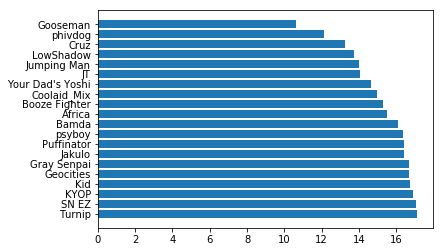

In [112]:
players = [player[0] for player in mu_sorted_ratings[-20:]]
ratings = [player[1].mu for player in mu_sorted_ratings[-20:]]
plt.barh(players, ratings)